# CSPB 3202 Final Project #

Tyler Kinkade, jaki9292@colorado.edu

GitHub: [https://github.com/jaki9292/rl-project](https://github.com/jaki9292/rl-project)

## Overview ##

This write-up reports on a small project to compare the effectiveness of reinforcement learning algorithms (Russell & Norvig, 2022; Sutton & Barto, 2018) within the Gymnasium (2022) "lunar lander" environment.

The report is divided into the following sections: approach, results, discussion, and suggestions.

## Approach ##

This section is divided into the following subsections: environment, models, methods.

### Environment ###

The lunar lander environment (pictured below) simulates rocket trajectory physics with the primary aim of landing a lunar lander on a central landing pad (marked by two flags) by means of turning its three rockets thrusters (left, right, and main) on or off. The agent operating the lander is rewarded for landing slowly, in an upright position, on both legs, on or near the landing pad and penalized otherwise. Fuel is unlimited, but a penalty is given for each time an engine fires. Scores of 200 points or more are considered a solution. 

The state space is described by an 8-vector comprised of the lander coordinates $(x,y)$, its linear velocities $(v_x,v_y)$ in the $x$ and $y$ directions, its angle $(\theta)$, its angular velocity $(\omega)$, and two Boolean variables $(l,r)$ for whether the left and right legs are in contact with the ground. The environment has both discrete and continuous versions, but only the discrete version is used here, in order to include simple models in the comparison. The environment gravity, wind power, and turbulence can also be specified. The starting state is the top center with a random force applied to it. The termination state occurs when the lander stops moving or moves outside the frame. The action space is comprised of 4 discrete actions: do nothing, fire left thruster, fire main down thruster, or fire right thruster.

In [1]:
# Display Lunar Lander GIF
from IPython.display import Image
Image(url= "https://gymnasium.farama.org/_images/lunar_lander.gif")

In [2]:
# Print environment parameters
# References: 
# https://gymnasium.farama.org/api/env/
# https://gymnasium.farama.org/environments/box2d/lunar_lander/

# Install dependencies
# pip install gymnasium
# pip install gymnasium[box2d]

import gymnasium as gym

# Initialize environment
env = gym.make("LunarLander-v2", 
               continuous = False,      # Discrete version
               gravity = -10.0, 
               enable_wind = False, 
               wind_power = 0.0, 
               turbulence_power = 0.0, 
               render_mode="rgb_array") # Render for machine

# Reset environment with random number generator seed for reproducibility
state, info = env.reset(seed = 21)

print("Environment metadata:\n", env.metadata)
print("\nState space:\n", env.observation_space)
print("\nAction space:\n", env.action_space)
print("\nStarting state:\n", state)

Environment metadata:
 {'render_modes': ['human', 'rgb_array'], 'render_fps': 50}

State space:
 Box([-90.        -90.         -5.         -5.         -3.1415927  -5.
  -0.         -0.       ], [90.        90.         5.         5.         3.1415927  5.
  1.         1.       ], (8,), float32)

Action space:
 Discrete(4)

Starting state:
 [ 0.00786695  1.4032904   0.796822   -0.33911794 -0.00910905 -0.18049194
  0.          0.        ]


The table below summarizes the descriptive statistics for 100 randomly sampled initial states for this environment. We can see that the initial linear and angular velocities vary more than the position and angular orientation.

In [3]:
import pandas as pd

# Determine average starting state from random sample of 100
starting_states = []
for _ in range(100):
    starting_state, info = env.reset()
    starting_states.append(starting_state)

features = ['x','y','vx','vy','angle','ang_vel','left_leg','right_leg']
starting_states_df = pd.DataFrame(starting_states, columns = features)
starting_states_df.describe()

,x,y,vx,vy,angle,ang_vel,left_leg,right_leg
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.0,100.0
mean,-0.000202,1.410030,-0.020460,-0.039560,0.000241,0.004635,0.0,0.0
std,0.004445,0.007046,0.450270,0.313165,0.005151,0.101993,0.0,0.0
min,-0.007806,1.398572,-0.790636,-0.548822,-0.009096,-0.180236,0.0,0.0
25%,-0.003390,1.404051,-0.343335,-0.305285,-0.003875,-0.076865,0.0,0.0
50%,-0.000128,1.409595,-0.012973,-0.058933,0.000155,0.002939,0.0,0.0
75%,0.003350,1.416666,0.339339,0.255355,0.003934,0.077771,0.0,0.0
max,0.007856,1.421770,0.795693,0.482209,0.009052,0.179091,0.0,0.0


### Models ###

Five models are compared in this project: an agentless lunar lander, a random agent, a simple reflex agent, a Q-learning agent, and an approximate reinforcement learning agent (Russell & Norvig, 2022; Sutton & Barto, 2018). 

An agentless lunar lander takes no action and is at the complete mercy of the environment. Because the starting state is directly above the landing pad, this might not be as terrible a strategy as it initially seems. The lander will simply fall to the ground in a trajectory determined by the physics of the environmental forces and the initial force placed upon it.

A random agent selects any of the possible actions uniformly randomly at each step without regard to the environment. The animation above is an example of such an agent, which appears to be a poor strategy. Is this a worse strategy than the "do-nothing" non-agent though?

A simple reflex agent can only react in a fixed way to sensory input but does not retain any memory of the past and, as a result, cannot learn. Depending on the algorithm, this could potentially be a better strategy than doing nothing or acting randomly.

A Q-learning agent alternates between learning through exploration and exploiting what it has learned by choosing the optimal policy for each state. Although this is obviously better than the relatively ignorant reflex agent, Q-learning agents can quickly become computationally expensive and slow to learn in large and complex environments. 

An approximate reinforcement learning agent is meant to address this issue by approximating a Q-learning agent through the use of a weighted linear approximation of the Q-values which it learns through exploration a certain amount of the time. Theoretically, this should simplify the computational demands.

It is expected that the last two models will perform better than the first three; however, it is possible that some difficulties might arise with the two learning agents. The environment might be too complex for the Q-learning agent to learn within a reasonable time. It is also possible that approximating the optimal choices may be insufficient. 

### Methods ###

Each model will be run for 100 episodes and their scores over each of the episodes will be plotted and compared. Visualizing each model's performance over successive episodes permits comparison of how each agent progressed in learning how to solve the model. As Machado and his colleagues (2018) point out, this is preferable to single metrics, such as maximum or average scores which can conceal important distinctions. For example, we can discover whether an agent achieved a maximum only once, but performed poorly most of the time. Similarly, an average score can conceal unstable, fluctuating performance. Ideally, we would like to see an agent learning quickly and then stably maintaining high scores above the solution threshold of 200 points.

Through this methodology, we will be able to explore the advantages and disadvantages of various models and demonstrate how a solution to the problem can be explored through the modfication of features and comparison of models.

## Results ## 

show the result and interpretation of your experiment. Any iterative improvements summary. demo clips
Does it include the results summary, interpretation of experiments and visualization (e.g. performance comparison table, graphs etc)?

In this section, I compare the five different models: a non-agent, a random agent, a simple reflex agent, a Q-learning agent, and an approximate reinforcement learning agent.

### Agentless Lunar Lander ###
First, we consider an agentless lunar lander which never fires any of its thrusters and is therefore subject entirely to its environment:

In [4]:
# Define general lunar lander class
# Adapted from: 
# CSPB 3202 Gym tutorial (https://applied.cs.colorado.edu/mod/folder/view.php?id=43136)
# https://gymnasium.farama.org/
# https://gymnasium.farama.org/api/utils/#save-rendering-videos
# https://gymnasium.farama.org/environments/box2d/lunar_lander/
# https://github.com/openai/gym/blob/master/gym/envs/box2d/lunar_lander.py

# Install dependencies
# pip install gymnasium
# pip install gymnasium[box2d]
# pip install moviepy

from gymnasium.utils.save_video import save_video
import numpy as np
from IPython.utils.capture import capture_output

# Action space
NOOP, LEFT, MAIN, RIGHT = 0, 1, 2, 3

class LunarLander:
    '''
    General lunar lander class 
    subject entirely to its environment
    '''   
    def __init__(self, name = "agentless"):
        '''
        Initialize agent
        '''
        self.name = name
        self.env = gym.make("LunarLander-v2", 
               continuous = False,           # Discrete version
               gravity = -10.0, 
               enable_wind = False, 
               wind_power = 0.0, 
               turbulence_power = 0.0, 
               render_mode="rgb_array_list") # Render for machine
        
        # Reset environment with random number generator seed for reproducibility
        self.state, self.info = self.env.reset(seed = 21)
        self.scores = []
        self.steps = []
        self.policy = []
        
    def select_action(self, state):
        '''
        Select action given state
        '''
        # Do nothing
        return NOOP

    def episode(self):
        '''
        Complete episode in given environment
        Return score, steps count, and actions log
        '''
        # Initialize rewards total
        score = 0.0

        # Initialize steps count
        step_count = 0

        # Initialize actions list
        actions = []

        # Start new episode  
        state, info = self.env.reset()

        # Until end of episode
        while True:
            # Get action based on current state
            action = self.select_action(state)

            # Obtain next state, reward, terminated status, truncated status, 
            # and environment info for given action
            next_state, reward, terminated, truncated, info = self.env.step(action)
            
            # Accumulate reward total
            score += reward

            # Increment steps count
            step_count += 1

            # Record action
            actions.append(action)

            # If end of episode
            if terminated or truncated:
                break  # out of loop
            
            # Advance to next state 
            state = next_state

        return score, step_count, actions
    
    def iterate(self, n = 100, verbose = False, video = False):
        '''
        Attempt task for n episodes
        '''
        # Initialize logs
        scores = []
        steps = []
        policy = []

        video_step_start = 0
        
        # Repeat n times
        for episode in range(n):
            # Complete one episode
            score, step_count, actions = self.episode()
            
            # Log scores, steps, policy
            scores.append(score)
            steps.append(step_count)
            policy.append(actions)

            # Update object attributes
            self.scores = scores
            self.steps = steps
            self.policy = policy

            if verbose:
                # Report result
                print(f"Episode {episode} score: {score}")

            if video:
                # Suppress MoviePy stdout
                # https://stackoverflow.com/a/35624406/14371011
                with capture_output() as captured:
                    # Save mp4 of every (k^3)th episode (0, 1, 8, 27, ...)
                    save_video(self.env.render(),
                               video_folder = "videos",
                               name_prefix = self.name,
                               fps = env.metadata["render_fps"],
                               step_starting_index = video_step_start,
                               episode_index = episode)

            # Advance starting step index for videos
            video_step_start = step_count + 1           
        
        return scores
    
    def score_stats(self, verbose = False):
        '''
        Return mean, max, and min of scores if they exist 
        '''
        # If scores exist
        if (len(self.scores) > 0):
            # Calculate average, max, and min
            average, max, min = np.average(self.scores), np.max(self.scores), np.min(self.scores)
            
            if verbose:
                # Report average, max, and min
                print(f"\nAverage score: {average}; Max: {max}; Min: {min}")
            return average, max, min
        else: 
            print("No scores have been calculated")
            return None, None, None

In [5]:
# For reference, the first 41 cubes (from https://oeis.org/A000578) are:
cubes = [0, 1, 8, 27, 64, 125, 216, 343, 512, 729, 1000, 1331, 1728, 2197, 2744, 3375, 4096, 4913, 5832, 6859, 8000, 9261, 10648, 12167, 13824, 15625, 17576, 19683, 21952, 24389, 27000, 29791, 32768, 35937, 39304, 42875, 46656, 50653, 54872, 59319, 64000]
len(cubes)

41

In [6]:
# Instantiate agentless lunar lander
non_agent = LunarLander()

# Number of episodes to iterate over
episodes = 100

# Iterate over 100 episodes
non_scores = non_agent.iterate(episodes, verbose = False, video = True)

# Print average, max, min
average, max, min = non_agent.score_stats(verbose = True)


Average score: -135.76963525976183; Max: -2.7733466088406544; Min: -270.4331423001463


[Link to the video of the agentless lander in the 65<sup>th</sup> episode](videos/agentless-episode-64.mp4)

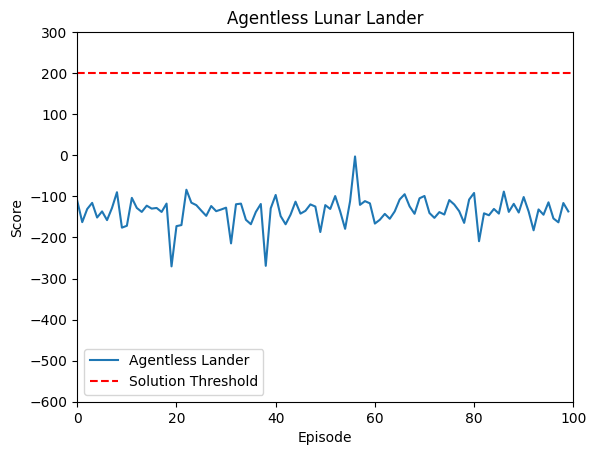

In [7]:
# Plot agentless lunar lander scores over all episodes

import matplotlib.pyplot as plt

plt.plot(non_scores, label = "Agentless Lander")
plt.axhline(y = 200, color = 'r', linestyle = 'dashed', label = "Solution Threshold")  
plt.xlim([0,episodes])
plt.ylim([-600,300])
plt.title("Agentless Lunar Lander")
plt.xlabel("Episode")
plt.ylabel("Score")
plt.legend();

In the above graph, we can see that an agentless lunar lander is not sufficient to solve this problem. In the video linked above, we can see the lunar lander simply falling in a slightly curved trajectory toward the ground.

### Random Agent ###

Next, we consider a random agent which selects any of the four possible actions randomly at each time step.

In [8]:
# Define random agent class

class RandomAgent(LunarLander):
    '''
    Inherits from lunar lander class
    and acts randomly
    '''
    def __init__(self, name = "random_agent"):
        LunarLander.__init__(self, name)

    def select_action(self, state):
        '''
        Randomly select action
        '''
        # Randomly select action from action space
        action = self.env.action_space.sample()

        return action

In [9]:
# Instantiate lunar lander random agent
rand_agent = RandomAgent()

# Iterate over episodes
rand_scores = rand_agent.iterate(episodes, verbose = False, video = True)

# Print average, max, min
average, max, min = rand_agent.score_stats(verbose = True)


Average score: -178.5137228762296; Max: 31.74032477640975; Min: -469.72753140795606


[Link to the video of the random agent in the 65<sup>th</sup> episode](videos/random_agent-episode-64.mp4)

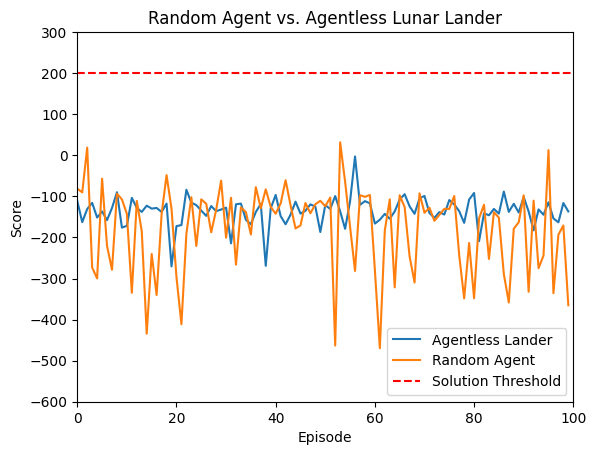

In [10]:
# Plot random agent's and non-agent's scores over all episodes

plt.plot(non_scores, label = "Agentless Lander")
plt.plot(rand_scores, label = "Random Agent")
plt.axhline(y = 200, color = 'r', linestyle = 'dashed', label = "Solution Threshold")  
plt.xlim([0,episodes])
plt.ylim([-600,300])
plt.title("Random Agent vs. Agentless Lunar Lander")
plt.xlabel("Episode")
plt.ylabel("Score")
plt.legend();

As the above graph shows, doing nothing is better than acting randomly in this environment. The agentless lunar lander is relatively more consistent and successful compared to the random agent and also has a slightly higher average score. Obviously, neither learn anything nor come remotely close to consistently reaching the solution threshold, as expected.

### Simple Reflex Agent ###

Next, we examine an agent which can fire its side thrusters in reaction to its current horizontal and angular velocity in relation to threshold constants chosen by the programmer. As explained in the environment section, the initial position is generally centered above the landing pad, but there is wide variation in initial linear and angular velocity. Thus, the primary task is counteracting any horizontal velocity while avoiding turning the ship on its side. Choosing ideal threshold constants requires tedious trial and error on the part of the programmer, rather than the agent. Thus, only the programmer is learning in this scenario.

In [131]:
class ReflexAgent(LunarLander):
    '''
    Inherits from lunar lander class, but 
    selects actions according to horizontal 
    and angular position and angular velocity
    '''
    def __init__(self, name = "reflex_agent"):
        LunarLander.__init__(self, name)

    def select_action(self, state):
        '''
        Select action according to horizontal and
        angular position and angular velocity
        '''
        # Set tolerances
        horiz_vel_tolerance = 0.4
        ang_vel_tolerance = 0.001

        # Horizontal velocity
        vx = state[3]

        # Angular velocity
        ang_vel = state[5]

        # If leftward horizontal velocity
        if ((vx < -horiz_vel_tolerance) and
            # and clockwise velocity
            (ang_vel > ang_vel_tolerance)):

            # Then, fire thruster to move right
            action = RIGHT
        
        # If rightward horizontal velocity
        elif ((vx > horiz_vel_tolerance) and
              # If counter-clockwise velocity
              (ang_vel < -ang_vel_tolerance)):
            
            # Then, fire thruster to move left
            action = LEFT

        else:
            # Do nothing
            action = NOOP
        
        return action 

In [132]:
# Instantiate lunar lander reflex agent
rflx_agent = ReflexAgent()

episodes = 100

# Iterate over episodes
rflx_scores = rflx_agent.iterate(episodes, verbose = False, video = True)

# Print average max, min
average, max, min = rflx_agent.score_stats(verbose = True)


Average score: -118.5233611373327; Max: -21.035651506373654; Min: -200.88517540938182


[Link to the video of the reflex agent in the 65<sup>th</sup> episode](videos/reflex_agent-episode-64.mp4)

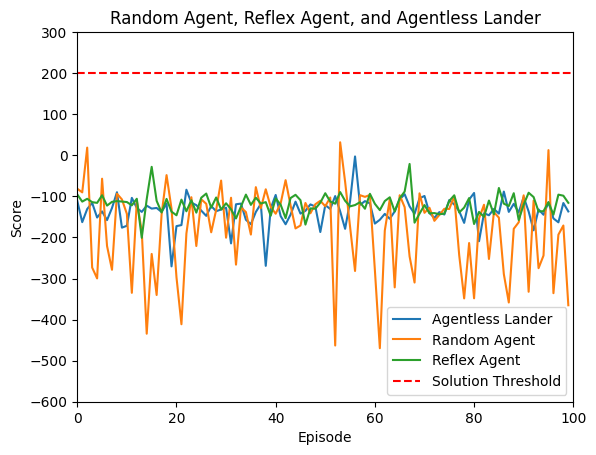

In [133]:
# Plot non-, random, and reflex agents' scores over all episodes

plt.plot(non_scores, label = "Agentless Lander")
plt.plot(rand_scores, label = "Random Agent")
plt.plot(rflx_scores, label = "Reflex Agent")
plt.axhline(y = 200, color = 'r', linestyle = 'dashed', label = "Solution Threshold")  
plt.xlim([0,episodes])
plt.ylim([-600,300])
plt.title("Random Agent, Reflex Agent, and Agentless Lander")
plt.xlabel("Episode")
plt.ylabel("Score")
plt.legend();

In the above graph, we can see that the reflex agent is relatively more consistent and successful compared to the random agent and also has a slightly higher average score, but it also did not improve over successive episodes, as expected. Landing a lunar rover appears to be more difficult than firing the left and right thrusters based on horizontal and angular position and angular velocity. In most of the videos, the lander is within the positional and angular velocity thresholds arbitrarily chosen above, so the reflex agent does nothing and occasionally gets lucky (see link to Episode 64 video above). It might be possible to achieve a higher score by comparing various algorithms and parameters through trial and error, but this would be a tedious process, so we would like to find a more expedient way to find the best policy to follow.

### Q-Learning Agent ###

### Approximate Reinforcement Leaning Agent ###

## Discussion ## 

Does it include discussion (what went well or not and why), and suggestions for improvements or future work?

## Suggestions for Future Research ##




## References ##

Gymnasium. (2022). _Gymnasium documentation._ Farama Foundation. [https://gymnasium.farama.org/](https://gymnasium.farama.org/)

Machado, M. C., Bellemare, M. G., Talvitie, E., Veness, J., Hausknecht, M., & Bowling, M. (2018). Revisiting the Arcade Learning Environment: Evaluation protocols and open problems for general agents. _Journal of Artificial Intelligence Research, 61,_ 523-562. [https://doi.org/10.1613/jair.5699](https://doi.org/10.1613/jair.5699)

Russell, S., & Norvig, R. (2022). Artificial intelligence: A modern approach, (4th ed.). Pearson. 

Sutton, R. S., & Barto, A. G. (2018). Reinforcement learning: An introduction. MIT Press.